# Porosity

In [5]:
import pandas as pd

porosity_df = pd.read_csv('linear_dependency.csv')

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

import numpy as np

In [9]:
x = porosity_df['d_param'].values.reshape(-1,1)
y = porosity_df['porosity_Schwarz_p'].values

x_train, y_train, x_test, y_test = train_test_split(x, y)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((15, 1), (5, 1), (15,), (5,))

In [17]:
degree = 3

x_poly = PolynomialFeatures(degree=degree).fit_transform(x)
print(x_poly.shape)
linear = LinearRegression()
linear.fit(x_poly, y)
y_pred = linear.predict(x_poly)
mse(y, y_pred)
print(linear.coef_)

(20, 4)
[ 0.         -0.06816784  0.04984266  0.01013945]


In [18]:
import matplotlib.pyplot as plt

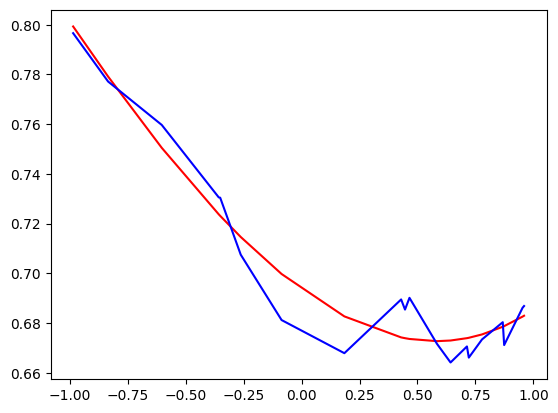

In [19]:
plt.plot(x, y_pred, c='red')
plt.plot(x, y, c='blue')

# Entropy

In [2]:
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

import numpy as np

entropy_df = pd.read_csv('entropy.csv')

In [5]:
print(entropy_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & Unnamed: 0 & d_param & Gyroid & Schwarz \\
\midrule
0 & 0 & -0.985086 & 7.828019 & 12.817731 \\
1 & 1 & -0.834337 & 8.086322 & 11.421037 \\
2 & 2 & -0.602925 & 8.421331 & 10.059915 \\
3 & 3 & -0.357099 & 8.694553 & 8.853321 \\
4 & 4 & -0.350885 & 8.698730 & 8.856987 \\
5 & 5 & -0.262321 & 8.778409 & 8.563515 \\
6 & 6 & -0.086151 & 8.893371 & 8.089089 \\
7 & 7 & 0.184648 & 8.821489 & 7.165093 \\
8 & 8 & 0.429486 & 8.609666 & 6.492101 \\
9 & 9 & 0.446178 & 8.594761 & 6.458588 \\
10 & 10 & 0.465395 & 8.577064 & 6.398883 \\
11 & 11 & 0.583936 & 8.452268 & 6.092819 \\
12 & 12 & 0.642550 & 8.380563 & 5.921346 \\
13 & 13 & 0.713229 & 8.281657 & 5.739262 \\
14 & 14 & 0.721315 & 8.267385 & 5.713075 \\
15 & 15 & 0.778426 & 8.178185 & 5.532658 \\
16 & 16 & 0.867778 & 8.030560 & 5.232656 \\
17 & 17 & 0.873779 & 8.022236 & 5.235386 \\
18 & 18 & 0.953246 & 7.872525 & 5.054533 \\
19 & 19 & 0.959561 & 7.865700 & 5.054643 \\
\bottomrule
\end{tabular}



- Schwarz:

        1-entropy is nice: `degree=3` or `degree=4`
        2-entropy is bad.
- Gyroid:

        1-entropy is nice: `degree 2,3,4`
        2-entropy is bad too

## Polynomial

In [101]:
def return_polynomial(variables, coefficients, eps=0.01):
    coeffs_str = list(map(lambda x: str(round(x,2)), coefficients))
    polynomial = " + ".join([coef + var for coef, var in 
                                 zip(coeffs_str[1:], variables[1:]) if np.abs(float(coef)) > eps])
    return coeffs_str[0] + " + " + polynomial

In [90]:
class PolynomialModel:
    def __init__(self, model_name="", degree=4, round_for_poly=0.01):
        self.degree = degree
        self.model_name = model_name
        self.model = Pipeline([('features', PolynomialFeatures(degree=degree)), 
                               ('linear', LinearRegression())])
        self.round_for_poly = round_for_poly

    def fit_eval(self, X_train, y_train, X_test=None, y_test=None):
        if X_test is None or y_test is None:
            X_test = X_train
            y_test = y_train

        self.model.fit(X_train, y_train)
        r_2_test = self.model.score(X_test, y_test)
        r_2_train = self.model.score(X_train, y_train)
        y_pred = self.model.predict(X_test)
        y_hat = self.model.predict(X_train)
        mse_test = mean_squared_error(y_test, y_pred)
        mse_train = mean_squared_error(y_train, y_hat)
        rmse_test = np.sqrt(mse_test)
        rmse_train = np.sqrt(mse_train)
        coeffs = self.return_coeffs()
        variables = self.return_variables()
        return {
                "r2_test": r_2_test, "r2_train": r_2_train, 
                "mse_test": mse_test, "mse_train": mse_train, 
                "rmse_test": rmse_test, "rmse_train": rmse_train,
                "coeffs": coeffs, "variables": variables,
            }
    
    def return_variables(self):
        return self.model['features'].get_feature_names_out(['x']).tolist()

    def return_formula(self):
        variables = self.return_variables()
        coeffs = self.model['linear'].coef_
        coeffs_str = list(map(lambda x: str(round(x,2)), coeffs))
        polynomial = " + ".join([coef + var for coef, var in 
                                 zip(coeffs_str, variables) if np.abs(float(coef)) > self.round_for_poly])
        return f"{self.model['linear'].intercept_:.2f} + " + polynomial

    def return_coeffs(self):
        coeffs = self.model['linear'].coef_
        bias = self.model['linear'].intercept_
        return np.array([bias] + [coef for coef in coeffs[1:]])
    
    def plot(self, X_train, y_train, X_test=None, y_test=None, title=None):
        if X_test is None or y_test is None:
            X_test = X_train
            y_test = y_train
            
        fig = plt.figure()
        plt.scatter(X_train, y_train, c='blue', label="train")
        plt.scatter(X_test, self.model.predict(X_test), c='red', label="pred")
        plt.scatter(X_test, y_test, c='purple', label="true")
        if title is None:
            plt.title(self.model_name + f": degree = {self.degree}")
        else:
            plt.title(title)
        plt.legend(loc='best')
        return fig

In [83]:
class Experiments():
    def __init__(self, model_class, data, n_splits=4, random_state=42):
        self.model_class = model_class
        self.data = data
        self.n_splits=n_splits
        self.random_state = random_state

    def _choose_values_from_list_of_dicts(self, list_of_dicts, key):
        result = [d[key] for d in list_of_dicts]
        return result

    def run_experiments(self, degrees = range(1,10), *args, **kwargs):
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        self.results = {}
        for deg in degrees:
            print(f"Current degree is {deg}")
            self.model = self.model_class(degree=deg, *args, **kwargs)
            experiment_results_list = [None] * self.n_splits
            
            for i, (train_index, test_index) in enumerate(kf.split(self.data['x'])):
                print(f"Fold {i}")
                X_train, y_train = self.data['x'][train_index,:], self.data['y'][train_index]
                X_test, y_test = self.data['x'][test_index,:], self.data['y'][test_index]
                experiment_results_for_fold = self.model.fit_eval(X_train, y_train, X_test, y_test)
                experiment_results_list[i] = experiment_results_for_fold

            experiment_results = {
                "r2_test_min": min(self._choose_values_from_list_of_dicts(experiment_results_list, "r2_test")),
                "r2_test_mean": np.mean(self._choose_values_from_list_of_dicts(experiment_results_list, "r2_test")),
                "r2_test_max": max(self._choose_values_from_list_of_dicts(experiment_results_list, "r2_test")),

                "r2_train_min": min(self._choose_values_from_list_of_dicts(experiment_results_list, "r2_train")),
                "r2_train_mean": np.mean(self._choose_values_from_list_of_dicts(experiment_results_list, "r2_train")),
                "r2_train_max": max(self._choose_values_from_list_of_dicts(experiment_results_list, "r2_train")),

                "mse_test_min": min(self._choose_values_from_list_of_dicts(experiment_results_list, "mse_test")),
                "mse_test_mean": np.mean(self._choose_values_from_list_of_dicts(experiment_results_list, "mse_test")),
                "mse_test_max": max(self._choose_values_from_list_of_dicts(experiment_results_list, "mse_test")),

                "mse_train_min": min(self._choose_values_from_list_of_dicts(experiment_results_list, "mse_train")),
                "mse_train_mean": np.mean(self._choose_values_from_list_of_dicts(experiment_results_list, "mse_train")),
                "mse_train_max": max(self._choose_values_from_list_of_dicts(experiment_results_list, "mse_train")),

                "rmse_test_min": min(self._choose_values_from_list_of_dicts(experiment_results_list, "rmse_test")),
                "rmse_test_mean": np.mean(self._choose_values_from_list_of_dicts(experiment_results_list, "rmse_test")),
                "rmse_test_max": max(self._choose_values_from_list_of_dicts(experiment_results_list, "rmse_test")),

                "rmse_train_min": min(self._choose_values_from_list_of_dicts(experiment_results_list, "rmse_train")),
                "rmse_train_mean": np.mean(self._choose_values_from_list_of_dicts(experiment_results_list, "rmse_train")),
                "rmse_train_max": max(self._choose_values_from_list_of_dicts(experiment_results_list, "rmse_train")),

                "coeffs_mean": list(map(lambda x: round(x, 3),
                                   np.mean(self._choose_values_from_list_of_dicts(experiment_results_list, "coeffs"), axis=0))),
                "variables": self._choose_values_from_list_of_dicts(experiment_results_list, "variables")[0]
            }


            self.results[deg] = experiment_results
        self.results_df = pd.DataFrame(self.results).T
        self.results_df = self.results_df.reset_index().rename(columns={"index":"degree"})

        return self.results_df

Current degree is 1
Fold 0
Fold 1
Fold 2
Fold 3
Current degree is 2
Fold 0
Fold 1
Fold 2
Fold 3
Current degree is 3
Fold 0
Fold 1
Fold 2
Fold 3
Current degree is 4
Fold 0
Fold 1
Fold 2
Fold 3
Current degree is 5
Fold 0
Fold 1
Fold 2
Fold 3
Current degree is 6
Fold 0
Fold 1
Fold 2
Fold 3
Current degree is 7
Fold 0
Fold 1
Fold 2
Fold 3
Current degree is 8
Fold 0
Fold 1
Fold 2
Fold 3
   degree r2_test_min r2_test_mean r2_test_max r2_train_min r2_train_mean  \
0       1    0.921498     0.944134    0.975309     0.959617      0.969963   
1       2    0.977017     0.979939    0.983399     0.992761      0.993901   
2       3    0.992195     0.995454    0.997891     0.999144      0.999335   
3       4    0.996936     0.998465    0.999375     0.999616      0.999718   
4       5    0.997139     0.998306    0.999125     0.999618      0.999739   
5       6    0.926527     0.978883    0.998883     0.999651      0.999799   
6       7    0.833197     0.951366    0.998427     0.999749      0.999892   


<Axes: title={'center': 'Gyroid'}, xlabel='degree', ylabel='RMSE'>

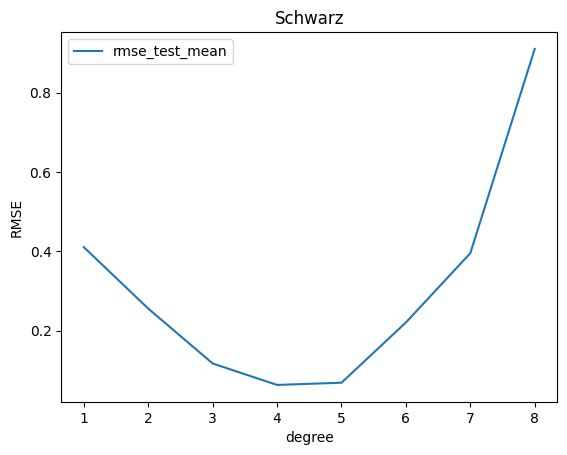

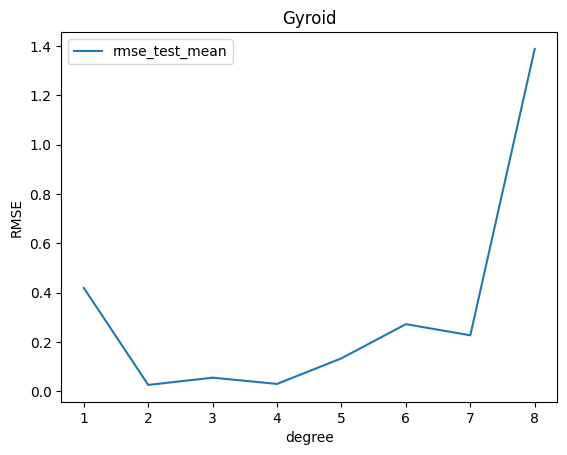

In [84]:
x = entropy_df['d_param'].values.reshape(-1,1)
data_schwarz = {'x': x, 'y': entropy_df['Schwarz'].values}
data_gyroid = {'x':x, 'y': entropy_df['Gyroid'].values}

MAX_DEG_POLYNOMIAL = 9
RANDOM_STATE = 21

schwarz_polynomial_experiments = Experiments(PolynomialModel, data_schwarz, random_state=RANDOM_STATE)
schwarz_polynomial_metrics = schwarz_polynomial_experiments.run_experiments(degrees=range(1,MAX_DEG_POLYNOMIAL))
print(schwarz_polynomial_metrics)
schwarz_polynomial_experiments.results_df.plot("degree", "rmse_test_mean", ylabel='RMSE', title="Schwarz")

gyroid_polynomial_experiments = Experiments(PolynomialModel, data_gyroid)
_ = gyroid_polynomial_experiments.run_experiments(degrees=range(1, MAX_DEG_POLYNOMIAL))
gyroid_polynomial_experiments.results_df.plot("degree", "rmse_test_mean", ylabel='RMSE', title="Gyroid")

In [85]:
schwarz_polynomial_experiments.results_df[['degree', 'rmse_test_mean', 'coeffs_mean', "variables"]]#.apply(lambda x: round(x,3))

,degree,rmse_test_mean,coeffs_mean,variables
0,1,0.410427,"[8.134, -3.503]","[1, x]"
1,2,0.255528,"[7.691, -3.639, 1.106]","[1, x, x^2]"
2,3,0.117023,"[7.66, -3.013, 1.152, -0.961]","[1, x, x^2, x^3]"
3,4,0.062917,"[7.739, -2.921, 0.523, -1.06, 0.656]","[1, x, x^2, x^3, x^4]"
4,5,0.068506,"[7.745, -2.972, 0.411, -0.711, 0.761, -0.323]","[1, x, x^2, x^3, x^4, x^5]"
5,6,0.220459,"[7.736, -3.055, 0.532, 0.094, -0.335, -1.021, ...","[1, x, x^2, x^3, x^4, x^5, x^6]"
6,7,0.395311,"[7.757, -3.065, -0.137, 0.545, 3.368, -4.746, ...","[1, x, x^2, x^3, x^4, x^5, x^6, x^7]"
7,8,0.910539,"[7.8, -3.1, -1.112, 1.519, 8.043, -10.625, -5....","[1, x, x^2, x^3, x^4, x^5, x^6, x^7, x^8]"


In [105]:
BEST_RMSE_TEST_MEAN_INDX_FOR_SCHWARZ = schwarz_polynomial_experiments.results_df['rmse_test_mean'].idxmin()
return_polynomial(schwarz_polynomial_experiments.results_df['variables'][BEST_RMSE_TEST_MEAN_INDX_FOR_SCHWARZ], 
                  schwarz_polynomial_experiments.results_df['coeffs_mean'][BEST_RMSE_TEST_MEAN_INDX_FOR_SCHWARZ])

'7.74 + -2.92x + 0.52x^2 + -1.06x^3 + 0.66x^4'

In [103]:
gyroid_polynomial_experiments.results_df[['degree', 'rmse_test_mean', 'coeffs_mean', "variables"]]#.apply(lambda x: round(x,3))

,degree,rmse_test_mean,coeffs_mean,variables
0,1,0.418837,"[8.419, -0.172]","[1, x]"
1,2,0.025773,"[8.833, -0.008, -1.063]","[1, x, x^2]"
2,3,0.055177,"[8.839, -0.039, -1.096, 0.074]","[1, x, x^2, x^3]"
3,4,0.029832,"[8.859, -0.014, -1.257, 0.032, 0.186]","[1, x, x^2, x^3, x^4]"
4,5,0.133599,"[8.865, -0.055, -1.368, 0.284, 0.437, -0.38]","[1, x, x^2, x^3, x^4, x^5]"
5,6,0.272051,"[8.88, -0.056, -1.578, 0.409, 0.887, -0.677, -...","[1, x, x^2, x^3, x^4, x^5, x^6]"
6,7,0.226815,"[8.881, -0.086, -1.676, 0.67, 1.512, -1.478, -...","[1, x, x^2, x^3, x^4, x^5, x^6, x^7]"
7,8,1.387404,"[8.892, -0.07, -1.942, 0.659, 3.061, -2.52, -3...","[1, x, x^2, x^3, x^4, x^5, x^6, x^7, x^8]"


In [106]:
BEST_RMSE_TEST_MEAN_INDX_FOR_GYROID = gyroid_polynomial_experiments.results_df['rmse_test_mean'].idxmin()
return_polynomial(gyroid_polynomial_experiments.results_df['variables'][BEST_RMSE_TEST_MEAN_INDX_FOR_GYROID], 
                  gyroid_polynomial_experiments.results_df['coeffs_mean'][BEST_RMSE_TEST_MEAN_INDX_FOR_GYROID])

'8.83 + -1.06x^2'

In [9]:
data_to_add_to_paper = pd.merge(
    schwarz_polynomial_experiments.results_df[['degree', 'rmse_test_mean']], 
    gyroid_polynomial_experiments.results_df[['degree', 'rmse_test_mean']], 
    on='degree'
    )
data_to_add_to_paper = data_to_add_to_paper.rename(
    columns={
        'rmse_test_mean_x' : 'Schwarz',
        'rmse_test_mean_y' : "Gyroid"
    }
)
data_to_add_to_paper.to_latex()#.plot('degree', ylabel='Mean test MSE')

'\\begin{tabular}{lrrr}\n\\toprule\n & degree & Schwarz & Gyroid \\\\\n\\midrule\n0 & 1 & 0.410427 & 0.418837 \\\\\n1 & 2 & 0.255528 & 0.025773 \\\\\n2 & 3 & 0.117023 & 0.055177 \\\\\n3 & 4 & 0.062917 & 0.029832 \\\\\n4 & 5 & 0.068506 & 0.133599 \\\\\n5 & 6 & 0.220459 & 0.272051 \\\\\n6 & 7 & 0.395311 & 0.226815 \\\\\n7 & 8 & 0.910539 & 1.387404 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [33]:
for deg in range(1,10):
    poly_schwarz = PolynomialModel(degree=deg)
    metrics = poly_schwarz.fit_eval(data_schwarz['x'], data_schwarz['y'])
    print(f"RMSE = {metrics['rmse_test']:.3f}", "\t", poly_schwarz.return_formula())

RMSE = 0.385 	 8.14 + -3.51x
RMSE = 0.183 	 7.68 + -3.65x + 1.13x^2
RMSE = 0.065 	 7.65 + -2.98x + 1.18x^2 + -1.01x^3
RMSE = 0.038 	 7.74 + -2.9x + 0.47x^2 + -1.1x^3 + 0.72x^4
RMSE = 0.036 	 7.74 + -2.97x + 0.45x^2 + -0.76x^3 + 0.74x^4 + -0.29x^5
RMSE = 0.036 	 7.73 + -2.98x + 0.58x^2 + -0.74x^3 + 0.4x^4 + -0.3x^5 + 0.24x^6
RMSE = 0.036 	 7.73 + -3.02x + 0.56x^2 + -0.38x^3 + 0.44x^4 + -1.06x^5 + 0.21x^6 + 0.46x^7
RMSE = 0.020 	 7.79 + -2.97x + -0.97x^2 + -0.91x^3 + 8.53x^4 + -0.11x^5 + -13.58x^6 + 0.03x^7 + 7.3x^8
RMSE = 0.011 	 7.81 + -3.29x + -1.53x^2 + 3.36x^3 + 11.5x^4 + -16.63x^5 + -18.38x^6 + 23.69x^7 + 9.65x^8 + -11.19x^9


In [11]:
for deg in range(1,10):
    poly_gyroid = PolynomialModel(degree=deg)
    metrics = poly_gyroid.fit_eval(data_gyroid['x'], data_gyroid['y'])
    print(f"RMSE = {metrics['rmse_test']:.3f}", "\t", poly_gyroid.return_formula())

RMSE = 0.319 	 8.40 + -0.14x
RMSE = 0.022 	 8.83 + -1.06x^2
RMSE = 0.021 	 8.83 + -0.03x + -1.06x^2 + 0.03x^3
RMSE = 0.014 	 8.86 + -1.28x^2 + 0.22x^4
RMSE = 0.013 	 8.86 + -0.04x + -1.29x^2 + 0.18x^3 + 0.23x^4 + -0.15x^5
RMSE = 0.008 	 8.88 + -0.03x + -1.59x^2 + 0.13x^3 + 1.03x^4 + -0.12x^5 + -0.55x^6
RMSE = 0.007 	 8.88 + -0.06x + -1.6x^2 + 0.39x^3 + 1.06x^4 + -0.67x^5 + -0.56x^6 + 0.33x^7
RMSE = 0.004 	 8.90 + -0.04x + -1.94x^2 + 0.27x^3 + 2.83x^4 + -0.46x^5 + -3.58x^6 + 0.24x^7 + 1.59x^8
RMSE = 0.002 	 8.90 + -0.1x + -2.03x^2 + 0.97x^3 + 3.32x^4 + -3.16x^5 + -4.36x^6 + 4.1x^7 + 1.98x^8 + -1.83x^9


(15, 1) (15,) (5, 1) (5,)


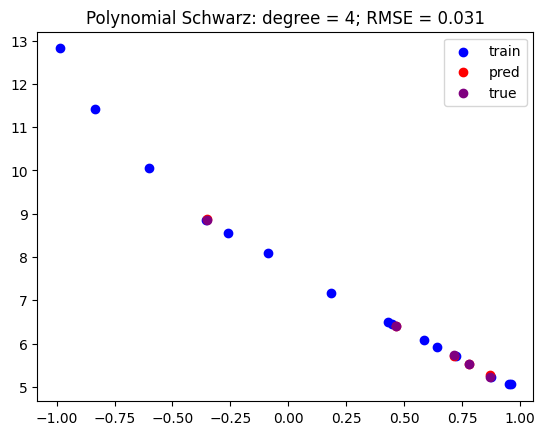

In [12]:
DEG = 4

poly_schwarz = PolynomialModel(degree=DEG, model_name="Schwarz")
X_train, X_test, y_train, y_test = train_test_split(data_schwarz['x'], data_schwarz['y'])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
metrics = poly_schwarz.fit_eval(X_train, y_train, X_test, y_test)

fig = poly_schwarz.plot(X_train, y_train, X_test, y_test, title=f"Polynomial Schwarz: degree = {DEG}; RMSE = {metrics['rmse_test']:.3f}")
plt.show()

### Train on whole

In [13]:
MAX_DEG = 6
rmse_schwarz = [None] * (MAX_DEG - 1)
rmse_gyroid = [None] * (MAX_DEG - 1)
for deg in range(1, MAX_DEG):
    schwarz_model = PolynomialModel(degree=deg)
    gyroid_model = PolynomialModel(degree=deg)
    schwarz_results = schwarz_model.fit_eval(data_schwarz['x'], data_schwarz['y'])
    gyroid_results = gyroid_model.fit_eval(data_gyroid['x'], data_gyroid['y'])
    rmse_schwarz[deg-1] = schwarz_results['rmse_train']
    rmse_gyroid[deg-1] = gyroid_results['rmse_train']

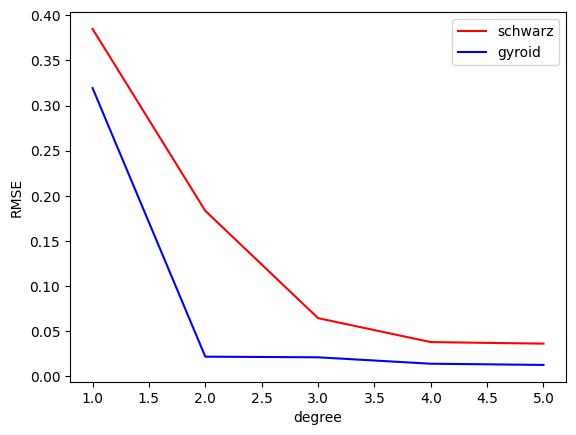

In [14]:
fig = plt.figure()
plt.plot(range(1,MAX_DEG), rmse_schwarz, c='red', label='schwarz')
plt.plot(range(1,MAX_DEG), rmse_gyroid, c='blue', label='gyroid')
plt.xlabel('degree')
plt.ylabel("RMSE")
plt.legend(loc='best')

## Exponential

In [15]:
class ExponentialModel(PolynomialModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def fit_eval(self, X_train, y_train, X_test=None, y_test=None):
        if X_test is None or y_test is None:
            X_test = X_train
            y_test = y_train

        self.model.fit(X_train, np.log(y_train))
        y_pred = np.exp(self.model.predict(X_test))
        y_hat = np.exp(self.model.predict(X_train))
        
        return {"r2_test": r2_score(y_test, y_pred), 
                "r2_train": r2_score(y_train, y_hat), 
                "mse_test": mean_squared_error(y_test, y_pred), 
                "mse_train": mean_squared_error(y_train, y_hat),
                "rmse_test": np.sqrt(mean_squared_error(y_test, y_pred)), 
                "rmse_train": np.sqrt(mean_squared_error(y_train, y_hat)),
                }


    def return_formula(self):
        variables = self.model['features'].get_feature_names_out(['x']).tolist()
        coeffs = self.model['linear'].coef_
        coeffs_str = list(map(lambda x: str(round(x,2)), coeffs))
        polynomial = " + ".join([coef + var for coef, var in 
                                 zip(coeffs_str, variables) if np.abs(float(coef)) > self.round_for_poly])
        return f"{np.exp(self.model['linear'].intercept_):.2f} * " + f"exp({polynomial})"
    
    def plot(self, X_train, y_train, X_test=None, y_test=None, title=None):
        if X_test is None or y_test is None:
            X_test = X_train
            y_test = y_train
            
        fig = plt.figure()
        plt.scatter(X_train, y_train, c='blue', label="train")
        plt.scatter(X_test, np.exp(self.model.predict(X_test)), c='red', label="pred")
        plt.scatter(X_test, y_test, c='purple', label="true")
        if title is None:
            plt.title(self.model_name + f": degree = {self.degree}")
        else:
            plt.title(title)
        plt.legend(loc='best')
        return fig

Current degree is 1
Fold 0
Formulae is 7.72 * exp(-0.43x)
Fold 1
Formulae is 7.85 * exp(-0.45x)
Fold 2
Formulae is 7.83 * exp(-0.45x)
Fold 3
Formulae is 7.80 * exp(-0.45x)
Current degree is 2
Fold 0
Formulae is 7.78 * exp(-0.41x + -0.04x^2)
Fold 1
Formulae is 7.76 * exp(-0.45x + 0.03x^2)
Fold 2
Formulae is 7.74 * exp(-0.46x + 0.03x^2)
Fold 3
Formulae is 7.66 * exp(-0.45x + 0.04x^2)
Current degree is 3
Fold 0
Formulae is 7.72 * exp(-0.39x + 0.02x^2 + -0.08x^3)
Fold 1
Formulae is 7.71 * exp(-0.39x + 0.03x^2 + -0.09x^3)
Fold 2
Formulae is 7.71 * exp(-0.39x + 0.03x^2 + -0.1x^3)
Fold 3
Formulae is 7.68 * exp(-0.39x + 0.04x^2 + -0.1x^3)
Current degree is 4
Fold 0
Formulae is 7.74 * exp(-0.38x + -0.13x^3 + 0.07x^4)
Fold 1
Formulae is 7.75 * exp(-0.39x + -0.09x^3 + 0.04x^4)
Fold 2
Formulae is 7.75 * exp(-0.38x + -0.02x^2 + -0.11x^3 + 0.05x^4)
Fold 3
Formulae is 7.71 * exp(-0.38x + -0.1x^3 + 0.03x^4)
Current degree is 5
Fold 0
Formulae is 7.77 * exp(-0.38x + -0.07x^2 + -0.07x^3 + 0.21x^4 + -0.1

<Axes: title={'center': 'Gyroid'}, xlabel='degree', ylabel='RMSE'>

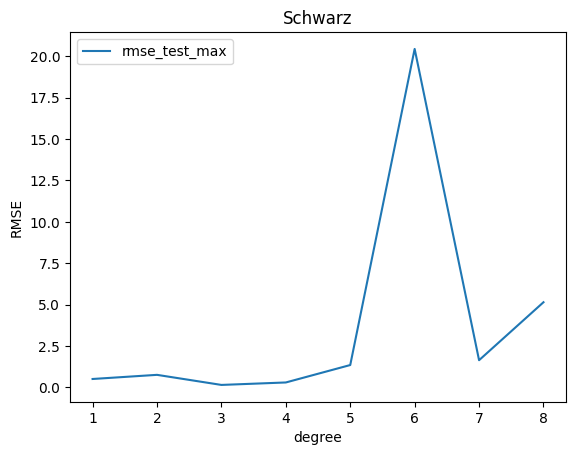

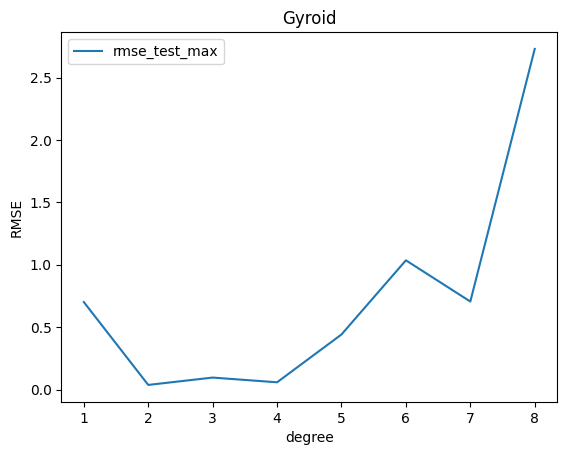

In [16]:
MAX_DEG_EXPONENTIAL = 9

schwarz_exponential_experiments = Experiments(ExponentialModel, data_schwarz)
schwarz_exponential_metrics = schwarz_exponential_experiments.run_experiments(degrees=range(1,MAX_DEG_EXPONENTIAL))
print(schwarz_exponential_metrics)
schwarz_exponential_experiments.results_df.plot("degree", "rmse_test_max", ylabel='RMSE', title="Schwarz")

gyroid_exponential_experiments = Experiments(ExponentialModel, data_gyroid)
gyroid_exponential_metrics = gyroid_exponential_experiments.run_experiments(degrees=range(1,MAX_DEG_EXPONENTIAL))
print(gyroid_exponential_metrics)
gyroid_exponential_experiments.results_df.plot("degree", "rmse_test_max", ylabel='RMSE', title="Gyroid")

In [17]:
schwarz_exponential_experiments.results_df[["degree", "rmse_test_mean"]]

,degree,rmse_test_mean
0,1,0.242320
1,2,0.305091
2,3,0.074146
3,4,0.112339
4,5,0.379184
5,6,5.164287
6,7,0.498869
7,8,1.340072


In [18]:
gyroid_exponential_experiments.results_df[["degree", "rmse_test_mean"]]

,degree,rmse_test_mean
0,1,0.424048
1,2,0.021064
2,3,0.040753
3,4,0.028396
4,5,0.124916
5,6,0.269900
6,7,0.192177
7,8,0.690750


(15, 1) (15,) (5, 1) (5,)


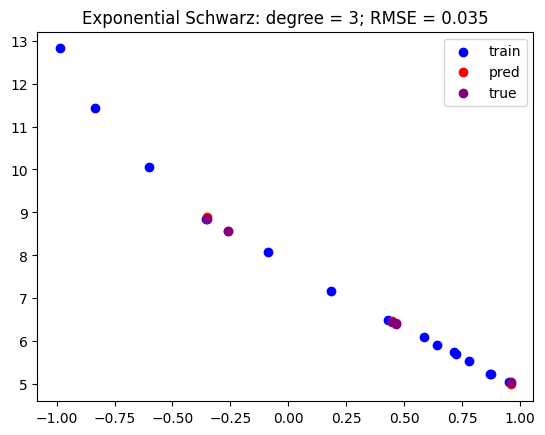

In [19]:
DEG = 3

poly_schwarz = ExponentialModel(degree=DEG, model_name="Schwarz")
X_train, X_test, y_train, y_test = train_test_split(data_schwarz['x'], data_schwarz['y'])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
metrics = poly_schwarz.fit_eval(X_train, y_train, X_test, y_test)

fig = poly_schwarz.plot(X_train, y_train, X_test, y_test, title=f"Exponential Schwarz: degree = {DEG}; RMSE = {metrics['rmse_test']:.3f}")
plt.show()

In [18]:
exponential_fit = np.polyfit(data_schwarz['x'].squeeze(), np.log(data_schwarz['y']), 1)
print(exponential_fit)

exponential_model_schwarz = ExponentialModel(data_schwarz, degree=1)
print(exponential_model_schwarz.fit())
print(exponential_model_schwarz.return_formula())


[-0.44803945  2.05484216]


AttributeError: 'ExponentialModel' object has no attribute 'fit'

In [19]:
#fit the model
x = x.squeeze()
y_schwarz = entropy_df['Schwarz'].values

exponential_fit = np.polyfit(x, np.log(y_schwarz), 2)

#view the output of the model
print(exponential_fit)

[ 0.02566328 -0.45120541  2.04445919]


In [20]:
exp_model = np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
#np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
#np.exp(exponential_fit[0] * x + exponential_fit[1]) 
mse(y_schwarz, exp_model)

NameError: name 'mse' is not defined

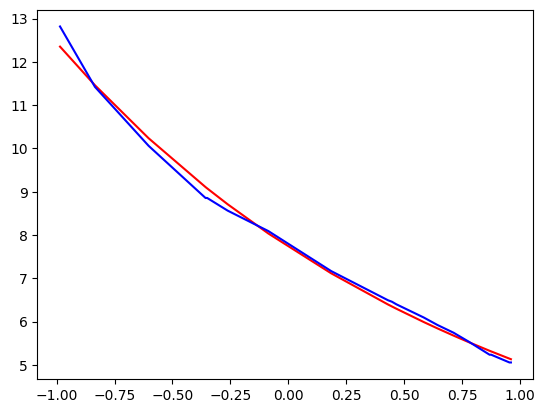

In [21]:
plt.plot(x, exp_model, c='red')
plt.plot(x, y_schwarz, c='blue')

In [22]:
y_gyroid = entropy_df['Gyroid'].values

exponential_fit = np.polyfit(x, np.log(y_gyroid), 2)
print(exponential_fit)

[-1.27552374e-01 -7.93674446e-04  2.17945386e+00]


In [23]:
exp_model = np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
#np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
#np.exp(exponential_fit[0] * x + exponential_fit[1]) 
#np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
mse(y_gyroid, exp_model)

NameError: name 'mse' is not defined

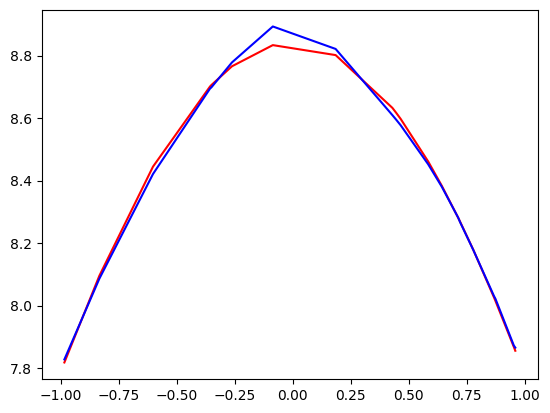

In [24]:
plt.plot(x, exp_model, c='red')
plt.plot(x, y_gyroid, c='blue')